#### Copyright 2017 Google LLC.

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

 # Introduction aux réseaux de neurones

 **Objectifs d'apprentissage :**
  * Définir un réseau de neurones et ses couches cachées à l'aide de la classe `DNNRegressor` de TensorFlow
  * Entraîner un réseau de neurones à apprendre des non-linéarités dans un ensemble de données et à être plus performant qu'un modèle de régression linéaire

 Dans les exercices précédents, des caractéristiques synthétiques ont été utilisées pour permettre au modèle d'incorporer des non-linéarités.

Un ensemble de non-linéarités important concernait la latitude et la longitude, mais il peut y en avoir d'autres.

Nous allons revenir, pour l'instant, à une tâche de régression standard plutôt qu'à la tâche de régression logistique de l'exercice précédent. En d'autres termes, nous allons prédire directement la valeur médiane d'un logement (`median_house_value`).

 ## Configuration

Commencez par charger et préparer les données.

In [0]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

In [0]:
def preprocess_features(california_housing_dataframe):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
  processed_features["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] /
    california_housing_dataframe["population"])
  return processed_features

def preprocess_targets(california_housing_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets["median_house_value"] = (
    california_housing_dataframe["median_house_value"] / 1000.0)
  return output_targets

In [4]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.6,2656.9,543.0,1439.6,504.7,3.9,2.0
std,2.1,2.0,12.6,2176.8,422.0,1127.3,384.8,1.9,1.2
min,32.5,-124.3,1.0,8.0,1.0,8.0,1.0,0.5,0.1
25%,33.9,-121.8,18.0,1471.0,298.0,793.0,283.0,2.6,1.5
50%,34.2,-118.5,29.0,2131.0,438.0,1173.0,411.0,3.5,1.9
75%,37.7,-118.0,37.0,3169.2,652.0,1735.0,607.0,4.8,2.3
max,42.0,-114.3,52.0,32627.0,6445.0,28566.0,6082.0,15.0,55.2


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.6,28.6,2611.8,530.9,1405.6,492.9,3.9,2.0
std,2.2,2.0,12.6,2187.4,420.2,1195.6,383.9,2.0,1.0
min,32.5,-124.3,1.0,2.0,2.0,3.0,2.0,0.5,0.0
25%,33.9,-121.8,18.0,1438.0,293.8,778.8,278.0,2.6,1.5
50%,34.2,-118.5,29.0,2119.5,427.0,1153.0,401.0,3.6,2.0
75%,37.7,-118.0,37.0,3104.0,637.0,1694.0,597.0,4.7,2.3
max,41.9,-114.6,52.0,37937.0,5471.0,35682.0,5189.0,15.0,34.2


Training targets summary:


,median_house_value
count,12000.0
mean,207.6
std,115.7
min,15.0
25%,120.1
50%,180.9
75%,264.3
max,500.0


Validation targets summary:


,median_house_value
count,5000.0
mean,206.6
std,116.6
min,15.0
25%,118.8
50%,178.8
75%,265.9
max,500.0


 ## Construction d'un réseau de neurones

Le réseau de neurones est défini par la classe [DNNRegressor](https://www.tensorflow.org/api_docs/python/tf/estimator/DNNRegressor).

Utilisez **`hidden_units`** pour définir la structure du réseau de neurones. L'argument `hidden_units` fournit une liste d'entiers ; chaque entier correspond à une couche cachée et indique le nombre de nœuds qu'il contient. Prenons comme exemple l'affectation suivante :

`hidden_units=[3,10]`

L'affectation ci-dessus spécifie un réseau de neurones avec deux couches cachées :

* La première couche cachée contient 3 nœuds.
* La deuxième couche cachée contient 10 nœuds.

Pour ajouter des couches, vous devez ajouter des entiers dans la liste. Par exemple, `hidden_units=[10,20,30,40]` créera quatre couches comportant respectivement dix, vingt, trente et quarante unités.

Par défaut, toutes les couches cachées utiliseront l'activation ReLU et seront entièrement connectées.

In [0]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a neural net regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                             
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [0]:
def train_nn_regression_model(
    learning_rate,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a neural network regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    hidden_units: A `list` of int values, specifying the number of neurons in each layer.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `DNNRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a DNNRegressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  dnn_regressor = tf.estimator.DNNRegressor(
      feature_columns=construct_feature_columns(training_examples),
      hidden_units=hidden_units,
      optimizer=my_optimizer
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["median_house_value"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["median_house_value"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["median_house_value"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    dnn_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  print("Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error)
  print("Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error)

  return dnn_regressor

 ## Tâche 1 : Entraîner un modèle de réseau de neurones

**Réglez les hyperparamètres, dans le but de faire passer la valeur RMSE en dessous de 110.**

Exécutez le bloc suivant pour entraîner un modèle de réseau de neurones.

Pour rappel, dans l'exercice de régression linéaire avec de nombreuses caractéristiques, une valeur RMSE d'environ 110 était plutôt satisfaisante. Nous allons essayer de faire mieux.

Votre objectif est ici de modifier divers paramètres d'apprentissage afin d'améliorer la justesse sur les données de validation.

Le surapprentissage représente un risque réel pour les réseaux de neurones. L'écart entre la perte sur les données d'apprentissage et la perte sur les données de validation est un bon indicateur pour déterminer si votre modèle commence à surapprendre. En règle générale, une augmentation de cet écart signale à coup sûr un surapprentissage.

Compte tenu de la pléthore de paramètres différents, il est vivement conseillé de prendre des notes à chaque tentative afin d'orienter le processus de développement.

De même, lorsque vous avez trouvé un paramètre satisfaisant, exécutez-le à plusieurs reprises afin de tester la répétabilité du résultat. En règle générale, les pondérations de réseau de neurones sont initialisées sur de petites valeurs aléatoires. Vous devriez donc constater des différences entre deux cycles d'exécution.


In [26]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.001,
    steps=2000,
    batch_size=100,
    hidden_units=[10, 10, 10],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on training data):
  period 00 : 174.07
  period 01 : 166.82
  period 02 : 163.56
  period 03 : 164.71


KeyboardInterrupt: ignored

 ### Solution

Cliquez ci-dessous pour afficher une solution.

 **REMARQUE :** Cette sélection de paramètres est quelque peu arbitraire. Dans le cas présent, nous avons essayé des combinaisons de plus en plus complexes, en allongeant la durée d'apprentissage, jusqu'à ce que l'erreur soit inférieure à l'objectif. Ce n'est en aucun cas la combinaison idéale ; d'autres peuvent atteindre une valeur RMSE encore plus basse. Si l'objectif est de trouver le modèle qui atteint la meilleure erreur, vous devrez utiliser une méthode plus rigoureuse ; une recherche de paramètres, par exemple.

Training model...
RMSE (on training data):
  period 00 : 164.29
  period 01 : 157.35
  period 02 : 152.25
  period 03 : 144.54
  period 04 : 141.69
  period 05 : 130.83
  period 06 : 127.05
  period 07 : 117.26
  period 08 : 113.79
  period 09 : 111.61
Model training finished.
Final RMSE (on training data):   111.61
Final RMSE (on validation data): 121.50


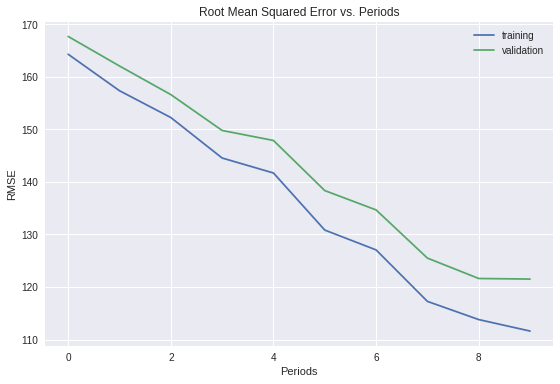

In [27]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.001,
    steps=2000,
    batch_size=100,
    hidden_units=[10, 10],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

 ## Tâche 2 : Effectuer une évaluation sur les données de test

**Vérifiez que vos performances de validation restent au même niveau sur les données de test.**

Dès que vous disposez d'un modèle satisfaisant, évaluez-le sur les données de test pour le comparer aux performances de validation.

Pour rappel, les données de test se trouvent [ici](https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv).

In [0]:
california_housing_test_data = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv", sep=",")

# YOUR CODE HERE

 ### Solution

Cliquez ci-dessous pour afficher une solution.

 Comme c'est le cas du code présenté ci-dessus, il vous suffit de charger le fichier de données approprié, de le prétraiter, puis d'appeler predict et mean_squared_error.

Notez qu'il n'est pas nécessaire de rendre les données de test aléatoires, dans la mesure où vous utiliserez tous les enregistrements.

In [28]:
california_housing_test_data = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv", sep=",")

test_examples = preprocess_features(california_housing_test_data)
test_targets = preprocess_targets(california_housing_test_data)

predict_testing_input_fn = lambda: my_input_fn(test_examples, 
                                               test_targets["median_house_value"], 
                                               num_epochs=1, 
                                               shuffle=False)

test_predictions = dnn_regressor.predict(input_fn=predict_testing_input_fn)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])

root_mean_squared_error = math.sqrt(
    metrics.mean_squared_error(test_predictions, test_targets))

print("Final RMSE (on test data): %0.2f" % root_mean_squared_error)

Final RMSE (on test data): 109.26
